In [0]:
import neural_process as nep
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

Sizes
  x: torch.Size([25]) 
  y: torch.Size([25]) 
for each task


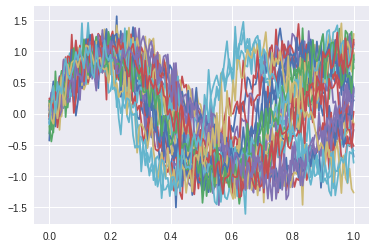

In [19]:
torch.manual_seed(19051994)
datasets = {}
n_tasks = 30
period = []

truth_x = torch.linspace(0, 1, 150)
x = torch.linspace(0, 1, 25)

for i in range(n_tasks):
    a = np.random.uniform(2, 4)
    y = torch.sin(a * np.pi * x) + torch.randn(x.size()) * 0.2
    truth_y = torch.sin(a * np.pi * truth_x) + torch.randn(truth_x.size()) * 0.2
    datasets['task_{}'.format(i)] = y.unsqueeze(-1), truth_y.unsqueeze(-1)
    plt.plot(truth_x.numpy(), truth_y.numpy())

# plt.title('Tasks')
# plt.ylabel('y = a sin(bx)')
# plt.xlabel('x')
print('Sizes\n', ' x:', x.shape, '\n  y:', y.shape, '\nfor each task')
plt.show()

In [0]:
x_dim = 1
y_dim = 1
r_dim = 3#8
z_dim = 3#8

encoder_specs = [(10, torch.nn.Tanh()), (10, torch.nn.Tanh()), 
                 #(10, torch.nn.Tanh()), 
                 #(10, torch.nn.Tanh()), (10, torch.nn.Tanh()), (10, torch.nn.Tanh()),
                 (r_dim, None)]

decoder_specs = [(10, torch.nn.Tanh()), (10, torch.nn.Tanh()), 
                 #(10, torch.nn.Tanh()), 
                 #(10, torch.nn.Tanh()), (10, torch.nn.Tanh()), (10, torch.nn.Tanh()),
                 (y_dim, None)]

encoder_input_dim = x_dim + y_dim 
decoder_input_dim = x_dim + z_dim

h = nep.Encoder(encoder_input_dim, encoder_specs, init_func=torch.nn.init.kaiming_normal_)
r_to_z = nep.Zparams(r_dim, z_dim)
g = nep.Decoder(decoder_input_dim, decoder_specs, init_func=torch.nn.init.kaiming_normal_)
optimizer = torch.optim.Adam(params=list(g.parameters()) + list(h.parameters()) + list(r_to_z.parameters()), lr=1e-3)

Epoch: 0


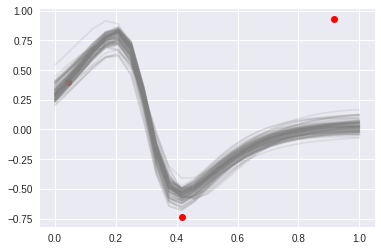

Epoch: 1000


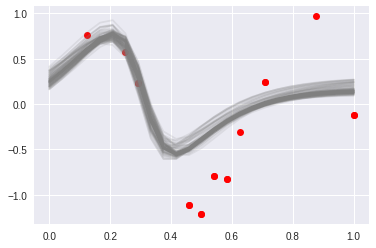

Epoch: 2000


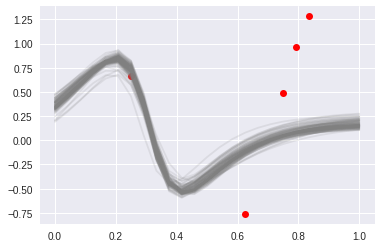

Epoch: 3000


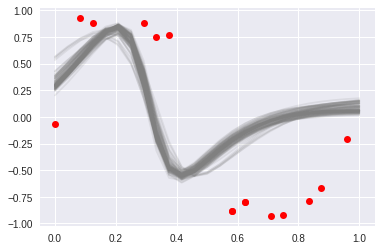

Epoch: 4000


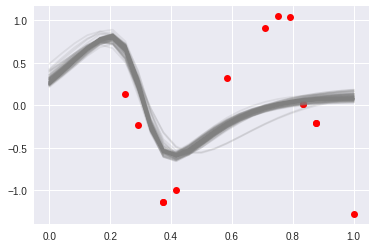

Epoch: 5000


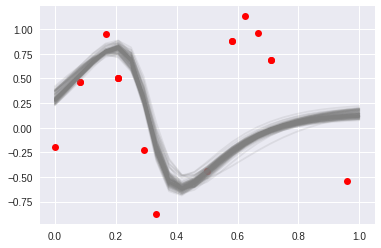

Epoch: 6000


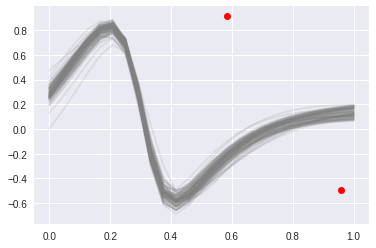

Epoch: 7000


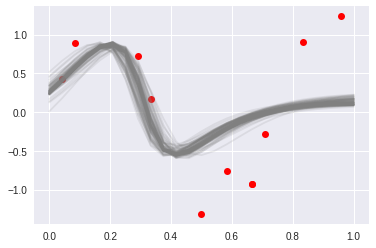

Epoch: 8000


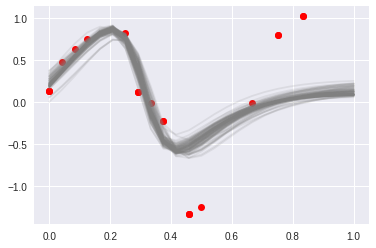

Epoch: 9000


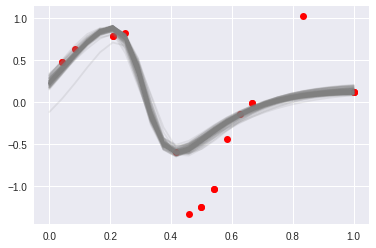

Training successful


In [16]:
epochs = 10000
loss = torch.nn.MSELoss()
losses = {i: [] for i,_ in datasets.items()}

x_t = x.unsqueeze(-1)

for epoch in range(epochs):
    optimizer.zero_grad()
    
    
    # select a task randomly
    task_id = 'task_' + str(np.random.randint(n_tasks))
    y_t, truth_y = datasets[task_id]
    
    
    # select number of context points randomly
    n_context = np.random.randint(1, x_t.shape[0])
    
    
    # select `n_context` points and create the context set and target set
    context_indeces = np.random.randint(x_t.shape[0], size=n_context)
    x_c = x_t[context_indeces]
    y_c = y_t[context_indeces]

    
    # variational parameters (mean, std) of approximate prior
    z_mean_c, z_std_c = r_to_z(h(x_c, y_c))
    
    
    # variational parameters (mean, std) of approximate posterior
    z_mean_t, z_std_t = r_to_z(h(x_t, y_t))
    
    
    # Monte Carlo estimate of log-likelihood (expectation wrt approximate posterior)
    #log_likelihood = nep.MC_loglikelihood(x_t, y_t, g, z_mean_t, z_std_t, 10)
    z_std_t = 10*z_std_t
    # compute KL divergence analytically
    KL = nep.KL_div(z_mean_t, z_std_t, z_mean_c, z_std_c) 
       
    # compute negative ELBO
    #ELBO = - log_likelihood + KL
    
    #kl.append(KL)
    #elbo.append(ELBO)
        
    # compute gradient of ELBO and take a gradient step
    #ELBO.backward()
    #optimizer.step()    
    
    z = nep.sample_z(z_mean_c, z_std_c, how_many=1)
    y_pred, _ = g(x_t, z)
    output = loss(y_pred, y_t) + KL
    losses[task_id].append(output)
    output.backward()
    optimizer.step() 
    
    
    if epoch % 1000 == 0:
        print('Epoch:', epoch)
        y_pred = nep.predict(x_t, g, z_mean_t, z_std_t, 100)

        # Plot of sample functions
        plt.plot(x_c.numpy(), y_c.numpy(), 'ro')
        for i in y_pred:
            plt.plot(x.numpy(), i, 'grey', alpha=0.15) 
        plt.show()

print('Training successful')

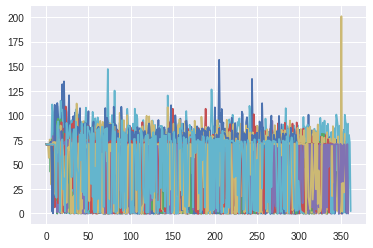

In [15]:
for i, j in losses.items():
    plt.plot(j)

In [17]:
y_pred = nep.predict(x_t, g, z_mean_t, z_std_t, 100)
quantile_05, median, quantile_95 = np.percentile(y_pred, [5, 50, 95], axis=0)

# Plot of sample functions
for i in y_pred:
    plt.plot(x_t.numpy(), i, 'grey', alpha=0.1)   
plt.plot(x_t.numpy(), y_t.numpy(), 'r--')
plt.show()
    
    
# Plot of distribution over functions
plt.plot(train_x.numpy(), train_y.numpy(), 'ro')
plt.plot(test_x.numpy().flatten(), test_y.numpy().flatten(), 'k*')
plt.plot(truth_x.numpy(), truth_y.numpy(), 'r--')
plt.plot(test_x.numpy().flatten(), median.flatten(), '--')
plt.fill_between(test_x.numpy().flatten(), quantile_05.flatten(), quantile_95.flatten(), alpha=0.15, facecolor='#089FFF')
plt.legend(['Training set', 'Test Set', 'True DGP', 'Prediction', 'Confidence'])
plt.show()

NameError: ignored

## New task

In [0]:
index_train = np.random.choice(y.shape[0], 10, replace=False)
y_new = torch.sin(3.5 * np.pi * x) + torch.randn(x.size()) * 0.2
y_new = y_new.unsqueeze(-1)
x_new = x.unsqueeze(-1)

y_new_train = y_new[index_train]
x_new_train = x_new[index_train]
print(index_train.shape)

(10,)


Epoch: 0


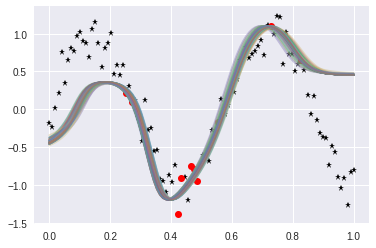

Training successful


In [0]:
epochs = 1000
loss = torch.nn.MSELoss()
compare = []

for epoch in range(epochs):
    optimizer.zero_grad()
    
    
    # select number of context points randomly
    n_context = np.random.randint(1, y_new_train.shape[0])
    
    
    # select `n_context` points and create the context set and target set
    context_indeces = np.random.choice(y_new_train.shape[0], n_context, replace=False)
    x_c = x_new_train[context_indeces]
    y_c = y_new_train[context_indeces]

    
    # variational parameters (mean, std) of approximate prior
    z_mean_c, z_std_c = r_to_z(h(x_c, y_c))
    
    # variational parameters (mean, std) of approximate posterior
    z_mean_t, z_std_t = r_to_z(h(x_new_train, y_new_train))
    
    # Monte Carlo estimate of log-likelihood (expectation wrt approximate posterior)
    #log_likelihood = nep.MC_loglikelihood(x_t, y_t, g, z_mean_t, z_std_t, 10)
    
    
    # compute KL divergence analytically
    #KL = nep.KL_div(z_mean_t, z_std_t, z_mean_c, z_std_c) 
    
    
    # compute negative ELBO
    #ELBO = - log_likelihood + KL
    
    z = nep.sample_z(z_mean_c, z_std_c, how_many=1)
    y_pred, _ = g(x_new_train, z)
    output = loss(y_pred, y_new_train) 
    compare.append(output)
    
    #kl.append(KL)
    #elbo.append(ELBO)
    
    
    
    # compute gradient of ELBO and take a gradient step
    #ELBO.backward()
    output.backward()
    optimizer.step()   
    
    
    
    if epoch % 1000 == 0:
        print('Epoch:', epoch)
        y_pred = nep.predict(x_new, g, z_mean_t, z_std_t, 100)

        # Plot of sample functions
        plt.plot(x_new.numpy(), y_new.numpy(), 'k*')
        plt.plot(x_new_train.numpy(), y_new_train.numpy(), 'ro')
        for i in y_pred:
            plt.plot(x_new.numpy(), i, alpha=0.4) 
        plt.show()
        
        
print('Training successful')
        

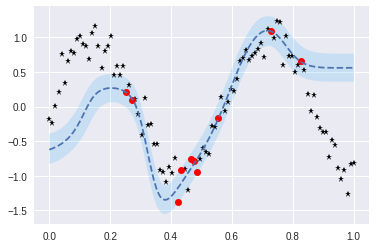

In [0]:
y_pred = nep.predict(x_new, g, z_mean_t, z_std_t, 100)
quantile_05, median, quantile_95 = np.percentile(y_pred, [5, 50, 95], axis=0)

plt.plot(x_new.numpy(), y_new.numpy(), 'k*')
plt.plot(x_new_train.numpy(), y_new_train.numpy(), 'ro')
plt.plot(x_new.numpy().flatten(), median.flatten(), '--')
plt.fill_between(x_new.numpy().flatten(), quantile_05.flatten()-0.2, quantile_95.flatten()+0.2, alpha=0.15, facecolor='#089FFF')
plt.show()